# Final Notebook: Poisoning, Data Selection, and Pruning
**Comparing:** Full data, Random subset, EL2N, Forgettability, and CRAIG-approx selection methods.

This notebook runs prototype experiments on CIFAR-10 with label-flip and backdoor poisons, computes
attack success rate (ASR), poison retention, clean accuracy, and shows comparison plots.

**Usage:** Set `PROTOTYPE = True` for quick runs on Colab/GPU. For final experiments, set `PROTOTYPE=False` and
increase epochs and repetitions.


In [1]:
# -------------------------
# Google Colab Setup
# -------------------------
try:
    import google.colab
    from google.colab import drive
    import os
    drive.mount('/content/drive')
    print("Google Drive mounted successfully")
    os.chdir("/content/drive/Othercomputers/My MacBook Pro/final_project_pruning")
    print(f"Changed directory to: {os.getcwd()}")
except:
    pass  # Not in Colab, skip mounting

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully
Changed directory to: /content/drive/Othercomputers/My MacBook Pro/final_project_pruning


In [2]:
# -------------------------
# Setup: installs, imports, reproducibility
# -------------------------
PROTOTYPE = False  # set False for full experiments

import random
import numpy as np
import torch, torch.optim as optim

# Seed for reproducibility
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Device:', device)

Device: cuda


In [3]:
# -------------------------
# Data transforms & load CIFAR-10
# -------------------------
if PROTOTYPE:
    train_epochs = 8
    batch_size = 128
    subset_frac = 0.25
    el2n_epochs = 3
    forget_epochs = 3
    craig_pretrain_epochs = 3
else:
    train_epochs = 50
    batch_size = 128
    subset_frac = 0.5
    el2n_epochs = 20
    forget_epochs = 20
    craig_pretrain_epochs = 10

data_root = './data'
num_workers = 0

In [4]:
from dataset import data_loaders
train_set, test_set, train_loader_full, test_loader = data_loaders(data_root, batch_size, num_workers)

Loaded CIFAR-10: train size 50000 test size 10000


In [5]:
from dataset import new_backdoor_dataset
from train_utils import *
from utils import *
from model import get_model
from el2n import compute_el2n_scores
from forgetting import compute_forgetting_scores
from craig import select_subset_craig
from prune import iterative_magnitude_prune_and_retrain
from torch.utils.data import DataLoader

# -------------------------
# Orchestrate all methods and evaluate
# -------------------------
def run_all_methods(poison_frac=0.02, subset_frac=0.25, selection_methods=None, device='cuda', num_workers=4):
    if selection_methods is None:
        selection_methods = ['full', 'random', 'el2n', 'forget', 'craig']

    results = {}

    # 1. Prepare Backdoor Dataset
    # We no longer check for poison_type; we assume backdoor.
    ds_poisoned = new_backdoor_dataset(data_root, poison_frac=poison_frac)
    poisoned_set = ds_poisoned.poisoned_idx

    n = len(ds_poisoned)
    k = int(n * subset_frac)
    print(f'Running Backdoor, poison_frac={poison_frac}, subset size {k} (of {n})')

    for method in selection_methods:
        print(f'\n---- Selection method: {method} ----')

        # 2. Select Indices
        if method == 'full':
            indices = list(range(n))
        elif method == 'random':
            indices = sample_random_indices(ds_poisoned, k, seed=seed)
        elif method == 'el2n':
            scores = compute_el2n_scores(get_model, ds_poisoned,
                                       epochs=el2n_epochs, device=device, num_workers=num_workers)
            indices = np.argsort(-scores)[:k].tolist()
        elif method == 'forget':
            scores = compute_forgetting_scores(get_model, ds_poisoned,
                                             epochs=forget_epochs, device=device, num_workers=num_workers)
            indices = np.argsort(-scores)[:k].tolist()
        elif method == 'craig':
            indices = select_subset_craig(get_model, ds_poisoned,
                                        subset_size=k, device=device, num_workers=num_workers,
                                        pretrain_epochs=craig_pretrain_epochs, seed=seed)

        kept, total_poison, retention = compute_poison_retention(poisoned_set, indices)
        print(f'Poison retention: {kept}/{total_poison} ({retention:.4f})')

        subset = subset_from_indices(ds_poisoned, indices)

        # 3. Train Dense Model with History Tracking
        model = get_model(device=device)
        opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=train_epochs, eta_min=1e-5)
        crit = nn.CrossEntropyLoss()

        train_loader = DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

        # Use train_with_history wrapper to track losses
        model, history = train_with_history(
            model, train_loader, test_loader, opt, scheduler, crit,
            epochs=train_epochs, device=device
        )

        # 4. Evaluate Dense Model
        loss, acc = evaluate(model, test_loader, device=device)

        # Removed the 'if poison_type == ...' check
        asr = compute_backdoor_asr(model, test_loader, trigger_patch_size=6, target_label=0, device=device)

        print(f'Dense model - Clean accuracy: {acc:.4f}, ASR: {asr:.4f}')

        # 5. Pruning & Retraining
        print("Applying iterative magnitude pruning...")
        pruned_model, mask = iterative_magnitude_prune_and_retrain(
            get_model,
            subset,
            test_loader,
            fraction_to_prune=0.3,
            iterations=2,
            rewind_epoch=1,
            epochs_per_cycle=10,
            num_workers=num_workers,
            device=device
        )

        ploss, pacc = evaluate(pruned_model, test_loader, device=device)
        pasr = compute_backdoor_asr(pruned_model, test_loader, trigger_patch_size=6, target_label=0, device=device)

        print(f'Pruned model - Clean accuracy: {pacc:.4f}, ASR: {pasr:.4f}')

        results[method] = {
            'subset_size': len(indices),
            'clean_acc': acc,
            'asr': asr,
            'poison_kept': kept,
            'poison_total': total_poison,
            'poison_retention': retention,
            'pruned_acc': pacc,
            'pruned_asr': pasr,
            'train_losses': history['train_losses'],
            'train_accs': history['train_accs'],
            'test_losses': history['test_losses'],
            'test_accs': history['test_accs'],
            'pruned_test_loss': ploss
        }

    return results

In [6]:
selection_methods = ['full', 'random', 'el2n', 'forget', 'craig']

In [7]:
# Backdoor experiment
res_backdoor = run_all_methods(poison_frac=0.02, subset_frac=subset_frac, selection_methods=selection_methods, device=device)
print('\nBackdoor results:'); print(res_backdoor)

Running Backdoor, poison_frac=0.02, subset size 25000 (of 50000)

---- Selection method: full ----
Poison retention: 1000/1000 (1.0000)


Dense model - Clean accuracy: 0.9423, ASR: 1.0000
Applying iterative magnitude pruning...
Training to rewind epoch 1...


Pruning iteration 1/2...
Pruning iteration 2/2...
Pruned model - Clean accuracy: 0.8934, ASR: 0.9988

---- Selection method: random ----
Poison retention: 993/1000 (0.9930)


Dense model - Clean accuracy: 0.9069, ASR: 1.0000
Applying iterative magnitude pruning...
Training to rewind epoch 1...


Pruning iteration 1/2...


Pruning iteration 2/2...
Pruned model - Clean accuracy: 0.7958, ASR: 0.9871

---- Selection method: el2n ----
EL2N Training Epoch 1/20


EL2N Training Epoch 2/20


EL2N Training Epoch 3/20


EL2N Training Epoch 4/20


EL2N Training Epoch 5/20


EL2N Training Epoch 6/20


EL2N Training Epoch 7/20


EL2N Training Epoch 8/20


EL2N Training Epoch 9/20


EL2N Training Epoch 10/20


EL2N Training Epoch 11/20


EL2N Training Epoch 12/20


EL2N Training Epoch 13/20


EL2N Training Epoch 14/20


EL2N Training Epoch 15/20


EL2N Training Epoch 16/20


EL2N Training Epoch 17/20


EL2N Training Epoch 18/20


EL2N Training Epoch 19/20


EL2N Training Epoch 20/20


Poison retention: 16/1000 (0.0160)


Dense model - Clean accuracy: 0.9266, ASR: 0.5750
Applying iterative magnitude pruning...
Training to rewind epoch 1...


Pruning iteration 1/2...


Pruning iteration 2/2...
Pruned model - Clean accuracy: 0.6999, ASR: 0.1123

---- Selection method: forget ----


Poison retention: 196/1000 (0.1960)


Dense model - Clean accuracy: 0.9315, ASR: 0.9994
Applying iterative magnitude pruning...
Training to rewind epoch 1...


Pruning iteration 1/2...
Pruning iteration 2/2...
Pruned model - Clean accuracy: 0.6835, ASR: 0.9992

---- Selection method: craig ----
Pre-training CRAIG model for 10 epochs (warmup: 10)...


  Epoch 1/10: Avg Loss = 2.3244


  Epoch 2/10: Avg Loss = 1.5895


  Epoch 3/10: Avg Loss = 1.1815


  Epoch 4/10: Avg Loss = 0.9206


  Epoch 5/10: Avg Loss = 0.7442


  Epoch 6/10: Avg Loss = 0.6487


  Epoch 7/10: Avg Loss = 0.5782


  Epoch 8/10: Avg Loss = 0.5317


  Epoch 9/10: Avg Loss = 0.5066


  Epoch 10/10: Avg Loss = 0.4816
Computing CRAIG gradient embeddings on trained model...


Gradient embedding extraction took 5.42 seconds
Performing per-class selection for better class balance...
  Class 0: selected 2942/5885 samples
  Class 1: selected 2455/4911 samples
  Class 2: selected 2452/4905 samples
  Class 3: selected 2448/4896 samples
  Class 4: selected 2451/4903 samples
  Class 5: selected 2448/4897 samples
  Class 6: selected 2448/4897 samples
  Class 7: selected 2451/4902 samples
  Class 8: selected 2445/4891 samples
  Class 9: selected 2456/4913 samples
CRAIG gradient matching took 21.23 seconds
CRAIG selected 24996 items total.
Poison retention: 22/1000 (0.0220)


Dense model - Clean accuracy: 0.8634, ASR: 0.8968
Applying iterative magnitude pruning...
Training to rewind epoch 1...


Pruning iteration 1/2...


Pruning iteration 2/2...
Pruned model - Clean accuracy: 0.7970, ASR: 0.1148

Backdoor results:
{'full': {'subset_size': 50000, 'clean_acc': 0.9423, 'asr': 1.0, 'poison_kept': 1000, 'poison_total': 1000, 'poison_retention': 1.0, 'pruned_acc': 0.8934, 'pruned_asr': 0.9988, 'train_losses': [2.02599390625, 1.401276875, 1.07456953125, 0.838633046875, 0.69841171875, 0.6023309765625, 0.5537713671875, 0.5141948828125, 0.4887071484375, 0.463350234375, 0.4446600390625, 0.4306045703125, 0.420163828125, 0.3936241796875, 0.3820121875, 0.3648296875, 0.3513740234375, 0.33966796875, 0.3278859765625, 0.31948921875, 0.30650693359375, 0.293020703125, 0.28272435546875, 0.2656312109375, 0.25641751953125, 0.24097892578125, 0.233068046875, 0.21443982421875, 0.20987630859375, 0.1925893359375, 0.17417939453125, 0.157546826171875, 0.147514755859375, 0.13752802734375, 0.122204033203125, 0.104393173828125, 0.090974716796875, 0.0745037841796875, 0.05756365234375, 0.0462401513671875, 0.03719492431640625, 0.02705982

In [8]:
from results import *

In [9]:
save_results_csv(res_backdoor, fname='backdoor_results_prototype.csv')

Saved results to backdoor_results_prototype.csv


In [10]:
# Save loss history to CSV
save_loss_history_csv(res_backdoor, fname='backdoor_loss_history_prototype.csv')

Saved loss history to backdoor_loss_history_prototype.csv


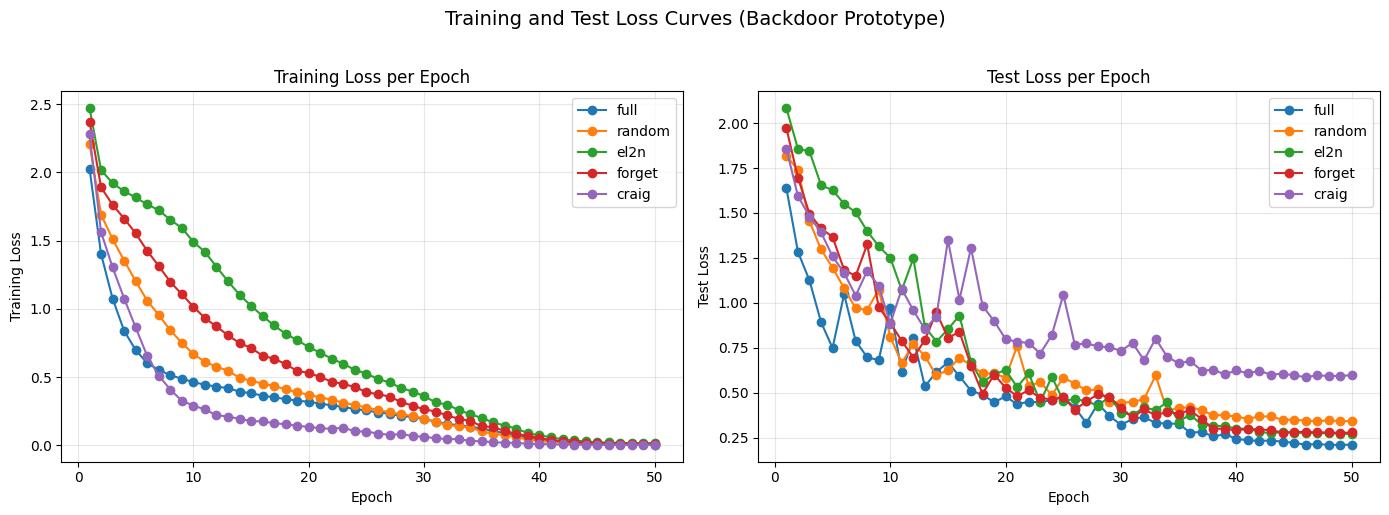

In [11]:
# Plot loss curves
plot_loss_curves(res_backdoor, title='Training and Test Loss Curves (Backdoor Prototype)')

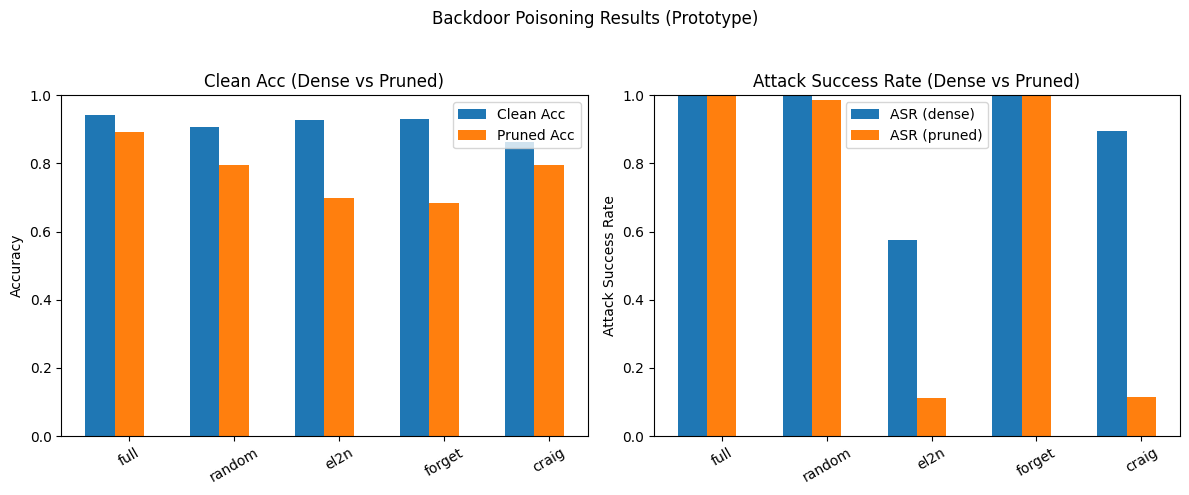

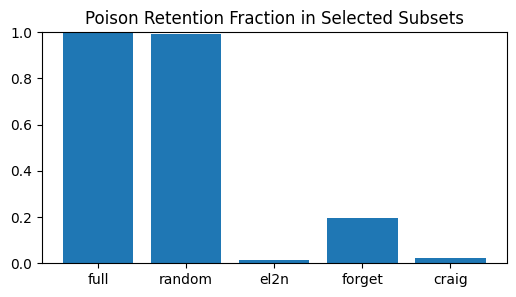

In [12]:
plot_results(res_backdoor, title='Backdoor Poisoning Results (Prototype)')